In [31]:
!pip install pyhocon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
!cp /content/experiments.conf .
!cp -r /content/METR .

cp: '/content/experiments.conf' and './experiments.conf' are the same file
cp: '/content/METR' and './METR' are the same file


In [33]:
import sys
import os
import torch
import argparse
import pyhocon
import random
import math
import copy
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from datetime import datetime


In [34]:
"""# Data Center"""

class DataCenter(object):

    def __init__(self, config):
        super(DataCenter, self).__init__()
        self.config = config

    def getPositionEmbedding(self,pos):
      input = np.arange(0,pos+1,1)
      a = input * 360
      day = a / 288
      week = a / 2016
      month = a / 8640
      day = np.deg2rad(day)
      week = np.deg2rad(week)
      day = np.sin(day)
      week = np.sin(week)
      combined = day+week
      return combined

  

    def load_data(self,ds,st_day,en_day,hr_sample,day,pred_len):

      content_file = self.config['file_path.' + ds + '_content']

      if ds=="PeMSD8" or ds == "METR":
        timestamp_data = np.load(content_file)
        timestamp_data = timestamp_data
      else:
        timestamp_data = []

        with open(content_file) as fp:
          for i, line in enumerate(fp):
            info = line.strip().split(",")
            info = [float(x) for x in info]

            timestamp_data.append(info)

      timestamp_data = np.asarray(timestamp_data)
      timestamp_data = timestamp_data.transpose()
      tot_node = timestamp_data.shape[0]
      tot_ts = timestamp_data.shape[1]
      
      st_day -= 1
      timestamp = 24 * hr_sample
      
      ts_data = []
      label_data = []
      
      for idx in range(st_day,en_day+1-day,1):

        st_point = idx*timestamp
        en_point = (idx+1)*timestamp


        last_hour = False
        for st in range(st_point, en_point):
          a_data = []
          
          if st + 12 + ((day-1)*timestamp) + pred_len == tot_ts:
            break

          for it in range(st,st+12):
            his = timestamp_data[:,(it+pred_len): it+pred_len+((day-1)*timestamp) :timestamp]
            cur = timestamp_data[:,it + (day-1)*timestamp].reshape(tot_node,1)
            a = np.concatenate((his,cur),axis=1).reshape(1,tot_node,day)
            a_data.append(a)
          
          a_data = np.concatenate(a_data,axis=0)
          
          pred_data = []
          for pred in range(pred_len):
            gt = timestamp_data[:,st + 12 + ((day-1)*timestamp) + pred].reshape(tot_node,1)
            pred_data.append(gt)
          
          pred_data = np.concatenate(pred_data,axis =1)

          ts_data.append(a_data)
          label_data.append(pred_data)
              
              
      return ts_data,label_data
    
    def load_adj(self,ds,dist = "METR_adj.csv",file_path_speed = "METR_speed.npy",k = 2):
      W = self.load_PeMSD(self.config['file_path.'+ ds +'_cites'])
      adj_lists = defaultdict(set)
      for row in range(len(W)):
        adj_lists[row] = set()
        for col in range(len(W)):
          if float(W[row][col]) >0 :
            adj_lists[row].add(col)
            adj_lists[col].add(row)
      d =pd.read_csv(dist, sep=',',header=None)
      distances = d.values

      adj = np.zeros(shape=(207,207))
      speeds = np.load(file_path_speed)
      avg_speeds = np.average(speeds,axis = 0)
      
      ffr = np.zeros(shape=(207,207))
      dt = 5
      
      # torch.from_numpy(a)
      for u in adj_lists:
        for v in adj_lists[u]:
            adj[u][v] = 1
            adj[v][u] = 1
      
      adj_khop = np.linalg.matrix_power(adj, k)
      for i in range(len(adj_khop)):
        for j in range(len(adj_khop[0])):
          if adj_khop[i][j]>=1:
            adj_khop[i][j]=1
          else:
            adj_khop[i][j]=0
      for i in range(len(adj_khop)):
        for j in range(len(adj_khop[0])):
          # print(avg_speeds[i])
          # print(dt*avg_speeds[i] - distances[i][j])
          if dt*avg_speeds[i] >=distances[i][j]: #here check
            ffr[i][j] = 1 
          else:
            ffr[i][j] = 0
      # final_adj = torch.zeros((len(adj_lists),len(adj_lists)))
      final_adj = np.zeros(shape=(170,170))
      final_adj = np.multiply(ffr,adj_khop)
      # print(final_adj)
      # for i in range(len(final_adj)):
        # for j in range(len(final_adj[0])):
          # final_adj[i][j] = np.matmul(ffr[i][j],adj[i][j]) - adj_khop[i][j]
      final_adj = torch.from_numpy(final_adj.astype(np.float32))
      print(final_adj.shape)
      print(type(final_adj))
      print(final_adj)
      return final_adj
        

    def load_PeMSD(self,file_path, sigma2=0.1, epsilon=0.5, scaling=True):

      try:
          W = pd.read_csv(file_path, header=None).values
      except FileNotFoundError:
          print('ERROR: No File Found.')
      
      n = W.shape[0]
      W = W / 10000.
      W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)

      return np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

In [35]:
"""# Utility Functions
"""

def evaluate(test_nodes,raw_features,labels, USTGCN, regression, device,test_loss):


    models = [USTGCN, regression]

    params = []
    for model in models:
        for param in model.parameters():
            if param.requires_grad:
                param.requires_grad = False
                params.append(param)

    
    val_nodes = test_nodes
    embs = USTGCN(raw_features,False)
    predicts = regression(embs)
    loss_sup = torch.nn.MSELoss()(predicts, labels)
    loss_sup /= len(val_nodes)
    test_loss += loss_sup.item()

    for param in params:
        param.requires_grad = True

    return predicts,test_loss

def RMSELoss(yhat,y):
    yhat = torch.FloatTensor(yhat)
    y = torch.FloatTensor(y)
    return torch.sqrt(torch.mean((yhat-y)**2)).item()


def mean_absolute_percentage_error(y_true, y_pred):
  print("Actual ",y_true)
  print("Predicted ",y_pred)
  y_true = np.asarray(y_true) + 1.6e8
  y_pred = np.asarray(y_pred)

  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
"""# Downstream Task"""

class Regression(nn.Module):

    def __init__(self, emb_size, out_size):
        super(Regression, self).__init__()

        self.layer = nn.Sequential(nn.Linear(emb_size, emb_size),
                                nn.ReLU(),
                                nn.Linear(emb_size, out_size),
                                nn.ReLU()
                                )
            

        self.init_params()

    def init_params(self):
        for param in self.parameters():
            if len(param.size()) == 2:
                nn.init.xavier_uniform_(param)

    def forward(self, embds):
        logists = self.layer(embds)
        return logists


In [37]:
"""# Data Loader"""

class DataLoader:

  def __init__(self, config,ds,pred_len):
    
    super(DataLoader, self).__init__()

    self.ds = ds
    self.dataCenter = DataCenter(config)

    if ds == "PeMSD7":
      train_st = 1
      train_en = 22

      test_st = 23
      test_en = 44 
      
    elif ds == "PeMSD8":
      train_st = 1
      train_en = 50

      test_st = 51
      test_en = 62 
    
    elif ds == "METR" :
      train_st = 1
      train_en = 47

      test_st = 48
      test_en = 58 
  
    self.train_st = train_st
    self.train_en = train_en
    self.test_st = test_st
    self.test_en = test_en

    self.hr_sample = 12
    self.day = 8
    self.pred_len = pred_len
    
  def load_data(self):
    print("Loading Data...")
    train_data,train_label = self.dataCenter.load_data(self.ds,self.train_st,self.train_en,self.hr_sample,self.day,self.pred_len)
    test_data,test_label = self.dataCenter.load_data(self.ds,self.test_st,self.test_en,self.hr_sample,self.day,self.pred_len)
    adj = self.dataCenter.load_adj(self.ds)
    print("Data Loaded")
    print("Dataset: ", self.ds)
    print("Total Nodes: ",adj.shape[0])
    print("Train timestamps: ",len(train_data))
    print("Test timestamps: ",len(test_data))
    print("Predicting After: ",self.pred_len*5,"minutes")

    return train_data,train_label,test_data,test_label,adj

In [38]:
"""# Traffic Model"""


class TrafficModel:

    def __init__(self, train_data, train_label, test_data, test_label, adj,
                 config, ds, input_size, out_size, GNN_layers,
                 epochs, device, num_timestamps, pred_len, save_flag, PATH, t_debug, b_debug):

        super(TrafficModel, self).__init__()

        self.train_data, self.train_label, self.test_data, self.test_label, self.adj = train_data, train_label, test_data, test_label, adj
        self.all_nodes = [i for i in range(self.adj.shape[0])]

        self.ds = ds
        self.input_size = input_size
        self.out_size = out_size
        self.GNN_layers = GNN_layers
        self.day = input_size
        self.device = device
        self.epochs = epochs
        self.regression = Regression(input_size * num_timestamps, pred_len)
        self.num_timestamps = num_timestamps
        self.pred_len = pred_len

        self.node_bsz = 512
        self.PATH = PATH
        self.save_flag = save_flag

        self.train_data = torch.FloatTensor(self.train_data).to(device)
        self.test_data = torch.FloatTensor(self.test_data).to(device)
        self.train_label = torch.FloatTensor(self.train_label).to(device)
        self.test_label = torch.FloatTensor(self.test_label).to(device)
        self.all_nodes = torch.LongTensor(self.all_nodes).to(device)
        self.adj = torch.FloatTensor(self.adj).to(device)

        self.t_debug = t_debug
        self.b_debug = b_debug

    def run_model(self):

        timeStampModel = CombinedGNN(self.input_size, self.out_size, self.adj,
                                     self.device, 1, self.GNN_layers, self.num_timestamps, self.day)
        timeStampModel.to(self.device)

        regression = self.regression
        regression.to(self.device)

        min_RMSE = float("Inf")
        min_MAE = float("Inf")
        min_MAPE = float("Inf")
        best_test = float("Inf")

        lr = 0.001

        train_loss = torch.tensor(0.).to(self.device)
        labelf=[]
        predf=[]
        for epoch in range(1, self.epochs):

            print("Epoch: ", epoch, " running... ")

            tot_timestamp = len(self.train_data)
            if self.t_debug:
                tot_timestamp = 60
            idx = np.random.permutation(tot_timestamp)

            for data_timestamp in idx:

                tr_data = self.train_data[data_timestamp]
                tr_label = self.train_label[data_timestamp]

                timeStampModel, regression, train_loss = apply_model(self.all_nodes, timeStampModel,
                                                                     regression, self.node_bsz, self.device, tr_data,
                                                                     tr_label, train_loss, lr, self.pred_len)

                if self.b_debug:
                    break

            train_loss /= len(idx)
            if epoch <= 24 and epoch % 8 == 0:
                lr *= 0.5
            else:
                lr = 0.0001

            print("Train avg loss: ", train_loss)

            pred = []
            label = []
            tot_timestamp = len(self.test_data)

            if self.t_debug:
                tot_timestamp = 60

            idx = np.random.permutation(tot_timestamp)
            test_loss = torch.tensor(0.).to(self.device)
            for data_timestamp in idx:

                # test_label
                raw_features = self.test_data[data_timestamp]
                test_label = self.test_label[data_timestamp]

                # evaluate
                temp_predicts, test_loss = evaluate(self.all_nodes, raw_features, test_label,
                                                    timeStampModel, regression, self.device, test_loss)

                label = label + test_label.detach().tolist()
                pred = pred + temp_predicts.detach().tolist()

                if self.b_debug:
                    break

            test_loss /= len(idx)
            print("Average Test Loss: ", test_loss)

            if test_loss <= best_test:
                best_test = test_loss
                pred_after = self.pred_len * 5
                if self.save_flag:
                    #print('here'+self.PATH + "/" + self.ds)
                    torch.save(timeStampModel,
                               self.PATH + self.ds + "/bestTmodel_" + str(pred_after) + "minutes.pth")
                    torch.save(regression,
                               self.PATH + self.ds + "/bestRegression_" + str(pred_after) + "minutes.pth")
            
            for ii in range(len(pred)):
              for jj in range(len(pred[0])):
                if pred[ii][jj]==0:
                  pred[ii][jj]=label[ii][jj]
            RMSE = torch.nn.MSELoss()(torch.FloatTensor(pred), torch.FloatTensor(label))
            RMSE = torch.sqrt(RMSE).item()
            print("PRED******LABEl")
            print(pred[1],label[1])
            MAE = mean_absolute_error(pred, label)
            MAPE = mean_absolute_percentage_error(label, pred)

            print("Epoch:", epoch)
            print("RMSE: ", RMSE)
            print("MAE: ", MAE)
            print("MAPE: ", MAPE)
            print("===============================================")

            min_RMSE = min(min_RMSE, RMSE)
            min_MAE = min(min_MAE, MAE)
            min_MAPE = min(min_MAPE, MAPE)
            
            labelf,predf=label,pred

            print("Min RMSE: ", min_RMSE)
            print("Min MAE: ", min_MAE)
            print("Min MAPE: ", min_MAPE)

            print("===============================================")

        return labelf, predf

    def run_Trained_Model(self):
        pred_after = self.pred_len * 5
        timeStampModel = torch.load(self.PATH + "/" + self.ds + "/bestTmodel_" + str(pred_after) + "minutes.pth")
        regression = torch.load(self.PATH + "/" + self.ds + "/bestRegression_" + str(pred_after) + "minutes.pth")
        pred = []
        label = []
        tot_timestamp = len(self.test_data)
        idx = np.random.permutation(tot_timestamp + 1 - self.num_timestamps)
        test_loss = torch.tensor(0.).to(self.device)

        for data_timestamp in idx:
            # test_label
            raw_features = self.test_data[data_timestamp]
            test_label = self.test_label[data_timestamp]

            # evaluate
            temp_predicts, test_loss = evaluate(self.all_nodes, raw_features, test_label,
                                                timeStampModel, regression, self.device, test_loss)

            label = label + test_label.detach().tolist()
            pred = pred + temp_predicts.detach().tolist()

        test_loss /= len(idx)
        print("Average Test Loss: ", test_loss)

        RMSE = torch.nn.MSELoss()(torch.FloatTensor(pred), torch.FloatTensor(label))
        RMSE = torch.sqrt(RMSE).item()
        MAE = mean_absolute_error(pred, label)
        MAPE = mean_absolute_percentage_error(label, pred)

        print("RMSE: ", RMSE)
        print("MAE: ", MAE)
        print("MAPE: ", MAPE)
        print("===============================================")
        return label, pred

In [39]:
"""# Spatio-Temporal GNN"""

class SPTempGNN(nn.Module):
  def __init__(self,D_temporal,A_temporal,num_timestamps,out_size,tot_nodes):
    super(SPTempGNN, self).__init__()
    
    self.tot_nodes = tot_nodes
    self.sp_temp = torch.mm(D_temporal,torch.mm(A_temporal,D_temporal))

    

    self.his_temporal_weight = nn.Parameter(torch.FloatTensor(num_timestamps,out_size))

    self.his_final_weight = nn.Parameter(torch.FloatTensor(2*(out_size),out_size))

  
  def forward(self,his_raw_features):
    his_self = his_raw_features
    his_temporal = self.his_temporal_weight.repeat(self.tot_nodes,1) * his_raw_features
    his_temporal = torch.mm(self.sp_temp,his_temporal)

    his_combined = torch.cat([his_self,his_temporal], dim=1)
    his_raw_features =F.relu(his_combined.mm(self.his_final_weight))


    return his_raw_features

In [40]:
"""# Combined GraphSAGE
"""

class CombinedGNN(nn.Module):
    def __init__(self,input_size,out_size, adj_lists,
                 device,st,GNN_layers,num_timestamps,day):
        super(CombinedGNN, self).__init__()

        self.st = st
        self.num_timestamps = num_timestamps
        self.out_size = out_size
        self.tot_nodes = adj_lists.shape[0]
        self.device = device
        self.adj_lists = adj_lists 
        self.GNN_layers = GNN_layers

        
        self.day = day

                
        self.his_weight = nn.Parameter(torch.FloatTensor(out_size, self.num_timestamps*out_size))
        self.cur_weight = nn.Parameter(torch.FloatTensor(1, self.num_timestamps*1))

        A = self.adj_lists
        dim = self.num_timestamps*self.tot_nodes

        A_temporal = torch.zeros(dim,dim).to(device)
        D_temporal = torch.zeros(dim,dim).to(device)
        identity = torch.eye(self.tot_nodes).to(device)

        for i in range(0, self.num_timestamps):
          for j in range(0, i+1):

            row_st = i*self.tot_nodes
            row_en = row_st + self.tot_nodes
            col_st = j*self.tot_nodes
            col_en = col_st + self.tot_nodes

            if i == j: #adj matrix  
              A_temporal[row_st:row_en,col_st:col_en] = A 
            else: #identity matrix
              A_temporal[row_st:row_en,col_st:col_en] = identity + A
        
        row_sum = torch.sum(A_temporal,0)

        for i in range(dim):
          D_temporal[i,i] = 1/max(torch.sqrt(row_sum[i]),1)      
        
        for i in range(GNN_layers):
          sp_temp = SPTempGNN(D_temporal,A_temporal,num_timestamps,out_size,self.tot_nodes)
          setattr(self, 'sp_temp_layer'+str(i), sp_temp)
          

        dim2 = self.num_timestamps*(out_size)
        self.final_weight = nn.Parameter(torch.FloatTensor(dim2, dim2))

        self.init_params()
        

        

    def init_params(self):
      

      for param in self.parameters():
          if(len(param.shape)>1):
            nn.init.xavier_uniform_(param)


    def forward(self,his_raw_features,isTrain):
      
      dim = self.num_timestamps*self.tot_nodes
      his_raw_features = his_raw_features[:,:,:self.day].view(dim,self.day)

      
      for i in range(self.GNN_layers):
        sp_temp = getattr(self, 'sp_temp_layer'+str(i))
        his_raw_features = sp_temp(his_raw_features)
        
      
      his_list = []

      for timestamp in range(self.num_timestamps):
        st = timestamp * self.tot_nodes
        en = (timestamp+1) * self.tot_nodes
        his_list.append(his_raw_features[st:en,:])

      his_final_embds = torch.cat(his_list,dim=1)


      final_embds = his_final_embds
      final_embds = F.relu(self.final_weight.mm(final_embds.t()).t())



      return final_embds

In [41]:
"""# Applying Model"""

def apply_model(train_nodes, CombinedGNN, regression, 
                node_batch_sz, device,train_data,train_label,avg_loss,lr,pred_len):


    models = [CombinedGNN, regression]
    params = []
    for model in models:
      for param in model.parameters():
          if param.requires_grad:
              params.append(param)



    optimizer = torch.optim.Adam(params, lr=lr, weight_decay=0)

    optimizer.zero_grad()  # set gradients in zero...
    for model in models:
      model.zero_grad()  # set gradients in zero

    node_batches = math.ceil(len(train_nodes) / node_batch_sz)

    loss = torch.tensor(0.).to(device)
    #window slide
    raw_features = train_data
    labels = train_label
    for index in range(node_batches):

      nodes_batch = train_nodes[index * node_batch_sz:(index + 1) * node_batch_sz]
      nodes_batch = nodes_batch.view(nodes_batch.shape[0],1)
      labels_batch = labels[nodes_batch]      
      labels_batch = labels_batch.view(len(labels_batch),pred_len)
      embs_batch = CombinedGNN(raw_features,True)  # Finds embeddings for all the ndoes in nodes_batch

      logists = regression(embs_batch)


      loss_sup = torch.nn.MSELoss()(logists, labels_batch)

      loss_sup /= len(nodes_batch)
      loss += loss_sup



    avg_loss += loss.item()

    loss.backward()
    for model in models:
      nn.utils.clip_grad_norm_(model.parameters(), 5) 
    optimizer.step()

    optimizer.zero_grad()
    for model in models:
      model.zero_grad()

    return CombinedGNN, regression,avg_loss


In [42]:
if not os.path.exists("METR"):
  os.mkdir("METR")

DEVICE: cuda:0
Traffic Forecasting GNN with Historical and Current Model
/content/
Loading Data...
torch.Size([207, 207])
<class 'torch.Tensor'>
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
Data Loaded
Dataset:  METR
Total Nodes:  207
Train timestamps:  11520
Test timestamps:  1152
Predicting After:  60 minutes
Running Trained Model...
Epoch:  1  running... 
Train avg loss:  tensor(2.1357, device='cuda:0')
Average Test Loss:  tensor(0.7725, device='cuda:0')
PRED******LABEl
[60.388221740722656, 59.5475959777832, 59.860504150390625, 57.67414855957031, 60.26152801513672, 60.657691955566406, 57.325965881347656, 56.874168395996094, 59.413204193115234, 57.844242095947266, 57.13609313964844, 57.167381286621094] [65.5, 62.125, 65.77777862548828, 66.5, 61.75, 65.88888549804688, 64.44444274

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train avg loss:  tensor(0.5957, device='cuda:0')
Average Test Loss:  tensor(0.5827, device='cuda:0')
PRED******LABEl
[65.96803283691406, 65.35098266601562, 65.13420104980469, 65.41283416748047, 64.46015167236328, 64.9540786743164, 64.91020965576172, 64.06460571289062, 65.03056335449219, 65.52658081054688, 65.92598724365234, 66.27204132080078] [61.875, 62.44444274902344, 62.5, 66.125, 66.75, 65.11111450195312, 66.42857360839844, 64.875, 64.75, 65.66666412353516, 63.625, 65.75]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train avg loss:  tensor(0.5855, device='cuda:0')
Average Test Loss:  tensor(0.5731, device='cuda:0')
PRED******LABEl
[62.36167526245117, 62.924320220947266, 62.64531707763672, 62.78761291503906, 63.051025390625, 63.07634735107422, 62.725013732910156, 63.078800201416016, 62.99302673339844, 62.815452575683594, 62.264400482177734, 62.281917572021484] [63.875, 66.375, 63.0, 64.88888549804688, 61.33333206176758, 63.25, 64.75, 64.625, 65.125, 63.5, 65.33333587646484, 64.375]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 3
RMSE:  9.621203422546387
MAE:  4.827334622677273
MAPE:  99.99996960323108
Min RMSE:  9.621203422546387
Min MAE:  4.718639731150789
Min MAPE:  99.99996869439643
Epoch:  4  running... 
Train avg loss:  tensor(0.5862, device='cuda:0')
Average Test Loss:  tensor(0.5803, device='cuda:0')
PRED******LABEl
[65.39109802246094, 65.86982727050781, 64.78217315673828, 65.74524688720703, 66.0404281616211, 65.69652557373047, 65.36992645263672, 65.38347625732422, 65.78646850585938, 66.0691146850586, 65.68682098388672, 66.1223373413086] [65.875, 66.375, 67.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train avg loss:  tensor(0.5845, device='cuda:0')
Average Test Loss:  tensor(0.5686, device='cuda:0')
PRED******LABEl
[63.337284088134766, 63.134979248046875, 63.233707427978516, 63.099952697753906, 62.72732162475586, 62.687347412109375, 62.519779205322266, 62.73973083496094, 62.83592987060547, 62.674156188964844, 62.47518539428711, 62.5715446472168] [57.0, 64.25, 63.11111068725586, 60.71428680419922, 65.25, 63.625, 63.5, 62.22222137451172, 61.5, 59.88888931274414, 52.375, 61.625]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 5
RMSE:  9.660316467285156
MAE:  5.141307292905937
MAPE:  99.99997005000034
Min RMSE:  9.621203422546387
Min MAE:  4.614853459300892
Min MAPE:  99.99996861324905
Epoch:  6  running... 
Train avg loss:  tensor(0.5785, device='cuda:0')
Average Test Loss:  tensor(0.5706, device='cuda:0')
PRED******LABEl
[63.95445251464844, 63.67822265625, 63.554866790771484, 63.768917083740234, 63.855682373046875, 64.1054458618164, 64.05913543701172, 64.2916259765625, 64.01960754394531, 64.08458709716797, 64.42601776123047, 64.78882598876953] [66.625, 65.25, 65.11111450195312, 65.75, 64.55555725097656, 65.375, 67.0, 66.875, 65.75, 65.375, 66.11111450195312, 66.125]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 6
RMSE:  9.654586791992188
MAE:  4.969651372735249
MAPE:  99.9999700073771
Min RMSE:  9.621203422546387
Min MAE:  4.614853459300892
Min MAPE:  99.99996861324905
Epoch:  7  running... 
Train avg loss:  tensor(0.5781, device='cuda:0')
Average Test Loss:  tensor(0.5690, device='cuda:0')
PRED******LABEl
[64.61398315429688, 64.47042083740234, 64.32262420654297, 64.34297180175781, 64.18423461914062, 64.46057891845703, 64.14369201660156, 64.53047180175781, 64.6068344116211, 64.52281951904297, 64.3934326171875, 64.67121887207031] [64.77777862548828, 65.0, 65.66666412353516, 66.25, 65.88888549804688, 65.0, 64.77777862548828, 64.625, 64.77777862548828, 62.625, 65.33333587646484, 63.55555725097656]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 7
RMSE:  9.674864768981934
MAE:  4.641750467390399
MAPE:  99.99996899873639
Min RMSE:  9.621203422546387
Min MAE:  4.614853459300892
Min MAPE:  99.99996861324905
Epoch:  8  running... 
Train avg loss:  tensor(0.5854, device='cuda:0')
Average Test Loss:  tensor(0.5663, device='cuda:0')
PRED******LABEl
[63.58103942871094, 64.25701141357422, 64.57221984863281, 64.35567474365234, 64.8696060180664, 64.59989166259766, 64.35694122314453, 64.7701644897461, 65.07643127441406, 64.57467651367188, 64.88442993164062, 64.98063659667969] [65.33333587646484, 62.44444274902344, 65.22222137451172, 65.11111450195312, 65.5, 64.77777862548828, 65.0, 65.66666412353516, 66.25, 65.88888549804688, 65.0, 64.77777862548828]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 8
RMSE:  9.662240982055664
MAE:  4.791824964258963
MAPE:  99.99996942384999
Min RMSE:  9.621203422546387
Min MAE:  4.614853459300892
Min MAPE:  99.99996861324905
Epoch:  9  running... 
Train avg loss:  tensor(0.5723, device='cuda:0')
Average Test Loss:  tensor(0.5579, device='cuda:0')
PRED******LABEl
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 9
RMSE:  9.5692138671875
MAE:  4.666414410363819
MAPE:  99.99996902291592
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996861324905
Epoch:  10  running... 
Train avg loss:  tensor(0.5766, device='cuda:0')
Average Test Loss:  tensor(0.5739, device='cuda:0')
PRED******LABEl
[60.59983825683594, 60.6274528503418, 60.95957565307617, 60.432106018066406, 61.32233810424805, 61.34954071044922, 61.17482376098633, 62.07929611206055, 61.18907165527344, 60.9964485168457, 61.115936279296875, 61.89875411987305] [61.5, 62.44444274902344, 62.77777862548828, 64.55555725097656, 52.44444274902344, 61.77777862548828, 62.77777862548828, 61.0, 59.75, 58.29999923706055, 59.125, 61.0]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 10
RMSE:  9.68035888671875
MAE:  5.191569381899466
MAPE:  99.99997015501374
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996861324905
Epoch:  11  running... 
Train avg loss:  tensor(0.5851, device='cuda:0')
Average Test Loss:  tensor(0.5837, device='cuda:0')
PRED******LABEl
[72.4595947265625, 70.27850341796875, 68.93575286865234, 69.66246032714844, 67.85658264160156, 69.80479431152344, 68.87710571289062, 67.4204330444336, 67.54399871826172, 67.24674987792969, 67.47808074951172, 67.11510467529297] [63.14285659790039, 57.55555725097656, 60.22222137451172, 59.625, 61.75, 59.88888931274414, 62.875, 58.66666793823242, 61.0, 65.0, 64.375, 65.125]
Actual  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 11
RMSE:  10.764827728271484
MAE:  5.699416269358456
MAPE:  99.99996763201486
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486
Epoch:  12  running... 
Train avg loss:  tensor(0.5850, device='cuda:0')
Average Test Loss:  tensor(0.5563, device='cuda:0')
PRED******LABEl
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 12
RMSE:  9.649129867553711
MAE:  4.836971651149902
MAPE:  99.99996958791667
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486
Epoch:  13  running... 
Train avg loss:  tensor(0.5816, device='cuda:0')
Average Test Loss:  tensor(0.5506, device='cuda:0')
PRED******LABEl
[66.42591857910156, 66.74073028564453, 66.49613952636719, 66.42930603027344, 65.35798645019531, 65.8900375366211, 65.60894775390625, 66.07769775390625, 65.66185760498047, 65.583984375, 64.94235229492188, 65.33560943603516] [68.0, 65.66666412353516, 66.875, 67.0, 66.33333587646484, 66.55555725097656, 66.33333587646484, 67.44444274902344, 67.33333587646484, 65.77777862548828, 66.66666412353516, 68.77777862548828]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 13
RMSE:  9.571172714233398
MAE:  4.639225394699614
MAPE:  99.99996880385751
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486
Epoch:  14  running... 
Train avg loss:  tensor(0.5732, device='cuda:0')
Average Test Loss:  tensor(0.5567, device='cuda:0')
PRED******LABEl
[65.10580444335938, 65.01787567138672, 63.2121467590332, 63.72891616821289, 63.88216781616211, 63.328556060791016, 62.95872497558594, 62.7684211730957, 62.55104446411133, 62.94340515136719, 62.562957763671875, 62.2483024597168] [66.625, 66.5, 65.33333587646484, 65.25, 64.625, 66.44444274902344, 65.44444274902344, 66.375, 65.625, 64.28571319580078, 66.55555725097656, 65.375]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 14
RMSE:  9.58228588104248
MAE:  5.0103920781596445
MAPE:  99.99996996135702
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486
Epoch:  15  running... 
Train avg loss:  tensor(0.5680, device='cuda:0')
Average Test Loss:  tensor(0.5758, device='cuda:0')
PRED******LABEl
[67.6305160522461, 67.08882141113281, 65.81952667236328, 67.15315246582031, 67.1503677368164, 66.01264190673828, 66.09652709960938, 65.77714538574219, 65.88297271728516, 66.29292297363281, 65.1789779663086, 65.97997283935547] [64.375, 65.625, 63.66666793823242, 62.375, 63.625, 65.625, 64.66666412353516, 64.875, 62.11111068725586, 64.625, 63.125, 60.625]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 15
RMSE:  9.822525978088379
MAE:  4.921907396071109
MAPE:  99.99996808799972
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486
Epoch:  16  running... 
Train avg loss:  tensor(0.5674, device='cuda:0')
Average Test Loss:  tensor(0.5702, device='cuda:0')
PRED******LABEl
[65.24628448486328, 65.03811645507812, 64.95536804199219, 65.13550567626953, 64.93525695800781, 66.12610626220703, 65.8616943359375, 65.86595153808594, 64.70295715332031, 64.89708709716797, 65.31417846679688, 63.717525482177734] [64.22222137451172, 63.375, 66.25, 65.75, 65.0, 69.0, 67.0, 66.875, 65.77777862548828, 67.22222137451172, 66.625, 65.0]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 16
RMSE:  9.738412857055664
MAE:  4.839749068529604
MAPE:  99.99996883957054
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486
Epoch:  17  running... 
Train avg loss:  tensor(0.5667, device='cuda:0')
Average Test Loss:  tensor(0.5753, device='cuda:0')
PRED******LABEl
[64.36978149414062, 63.92195510864258, 64.84483337402344, 64.68074798583984, 64.45818328857422, 64.52088165283203, 64.1518325805664, 64.06531524658203, 64.52674102783203, 64.90595245361328, 63.81914138793945, 64.81827545166016] [65.22222137451172, 66.375, 57.77777862548828, 65.0, 64.5, 64.66666412353516, 64.71428680419922, 64.75, 65.75, 65.22222137451172, 66.125, 64.55555725097656]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 17
RMSE:  9.732608795166016
MAE:  4.838388154585968
MAPE:  99.9999692210667
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486
Epoch:  18  running... 
Train avg loss:  tensor(0.5951, device='cuda:0')
Average Test Loss:  tensor(0.6473, device='cuda:0')
PRED******LABEl
[60.8855094909668, 60.7607421875, 62.3492431640625, 61.22709655761719, 62.2224235534668, 61.38306427001953, 62.14566421508789, 62.28336715698242, 63.0014533996582, 63.09455108642578, 62.44450759887695, 64.531982421875] [64.88888549804688, 66.55555725097656, 65.125, 62.71428680419922, 0.0, 65.25, 63.55555725097656, 67.33333587646484, 67.88888549804688, 66.11111450195312, 66.875, 68.11111450195312]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 18
RMSE:  10.370317459106445
MAE:  6.356011145540772
MAPE:  99.99997110800086
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486
Epoch:  19  running... 
Train avg loss:  tensor(0.5964, device='cuda:0')
Average Test Loss:  tensor(0.6122, device='cuda:0')
PRED******LABEl
[65.93843078613281, 65.3300552368164, 65.8114013671875, 65.23667907714844, 65.20281219482422, 64.7944564819336, 64.62287902832031, 64.99250030517578, 65.45138549804688, 64.64332580566406, 64.90904235839844, 65.23652648925781] [66.71428680419922, 65.5, 67.22222137451172, 63.5, 68.5, 62.25, 64.11111450195312, 59.22222137451172, 64.75, 64.375, 61.55555725097656, 58.625]
Actual  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 19
RMSE:  10.125529289245605
MAE:  5.017695568115908
MAPE:  99.99996774691279
Min RMSE:  9.5692138671875
Min MAE:  4.614853459300892
Min MAPE:  99.99996763201486

238464 238464
[53.85714340209961, 51.875, 57.0, 61.0, 53.75, 59.0, 56.33333206176758, 52.33333206176758, 61.75, 64.75, 61.88888931274414, 49.0]


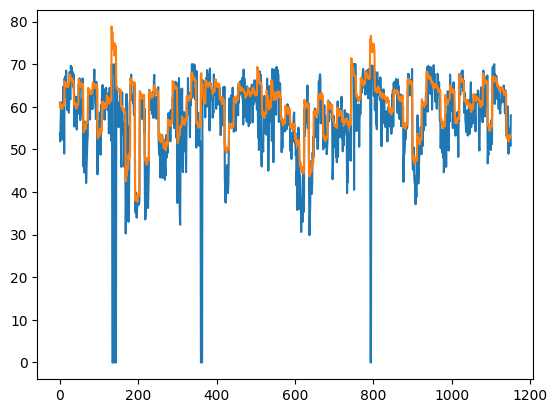

In [43]:
def main():
  # parser.add_argument('--trained_model', action='store_true')
  # parser.add_argument('--save_model', action='store_true')





  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print('DEVICE:', device)

  
  """# Main Function"""
  import matplotlib.pyplot as plt

  print('Traffic Forecasting GNN with Historical and Current Model')

  #set user given seed to every random generator
  seed_default = 42
  random.seed(seed_default)
  np.random.seed(seed_default)
  torch.manual_seed(seed_default)
  torch.cuda.manual_seed_all(seed_default)

  PATH = os.getcwd() + "/"
  print(PATH)
  config_file = "/content/experiments.conf"

  config = pyhocon.ConfigFactory.parse_file(config_file)
  ds = "METR"
  pred_len = 12
  data_loader = DataLoader(config,ds,pred_len)
  train_data,train_label,test_data,test_label,adj = data_loader.load_data()

  num_timestamps = 12
  GNN_layers = 3
  input_size = 8
  out_size = 8
  epochs = 20


  save_flag = True
  t_debug = False
  b_debug = False
  hModel = TrafficModel(train_data,train_label,test_data,test_label,adj,config, ds, input_size, 
                        out_size,GNN_layers,epochs, device,num_timestamps,pred_len,save_flag,
                        PATH,t_debug,b_debug)

  _trained_model = False
  if not _trained_model: #train model and evaluate
    print("Running Trained Model...")
    label,pred=hModel.run_model()
    print()
    print(len(label),len(pred))
    labelf=[]
    predf=[]
    for i in range(96):
      for j in range(pred_len):
        labelf.append(label[i][j])
        predf.append(pred[i][j])
    plt.plot(labelf)
    plt.plot(predf)
    print(label[0])
  else:
    print("Running Trained Model...")
    label,pred = hModel.run_Trained_Model() #run trained model
main()

In [44]:
import numpy as np
matrix = np.load('/content/METR_speed.npy')

In [45]:
matrix.shape

(34272, 207)